In [ ]:
!pip install ultralytics -q

In [ ]:
!gdown --fuzzy "https://drive.google.com/file/d/1PWKJrkHmDhml8gqDZzoDdtn6-_UtZoID/view?usp=drivesdk" -O dataset.zip
!unzip -o dataset.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/images/DJI_0187_JPG.rf.6ad18de65e2cdd51ce09b8006dba4f8a.jpg  
  inflating: /content/train/images/DJI_0187_JPG.rf.8d76659b2a48e0092ed285654c2628e9.jpg  
  inflating: /content/train/images/DJI_0188_JPG.rf.e36fdbce749b51d717439d0bab93d4c4.jpg  
  inflating: /content/train/images/DJI_0188_JPG.rf.e5d9eeb13a5f8aff097c3bebf042c5b3.jpg  
  inflating: /content/train/images/DJI_0189_JPG.rf.0507a7fd7e5391e08153a89c517e29f6.jpg  
  inflating: /content/train/images/DJI_0189_JPG.rf.6cf3c7bf2a6d5908cc1d167f439405f5.jpg  
  inflating: /content/train/images/DJI_0190_JPG.rf.3b148fe420d33aee9defc20dec9b0a51.jpg  
  inflating: /content/train/images/DJI_0190_JPG.rf.6e4df69f2e817b9e686fabb207e62d19.jpg  
  inflating: /content/train/images/DJI_0190_JPG.rf.daa460bb185951368fdaf74657214481.jpg  
  inflating: /content/train/images/DJI_0191_JPG.rf.515264bdf16c7fd57be255bd4601d853.jpg  
  inflating: /content/train/images/DJI_0191_JPG.r

In [ ]:
!ls

dataset.zip  data.yaml	sample_data  test  train  valid


In [ ]:
import os

train_path = "/content/train/images"

files = os.listdir(train_path)
print(files[:10])   # show first 10 files


['DJI_0091_JPG.rf.86205426989f122a3f9427c0d1e5bde2.jpg', '16_png.rf.f7987c1b2a14c7a9123a840851ba6a17.jpg', 'DJI_0104_JPG.rf.6bb2359a4bfbd8aa16af92413b2a899e.jpg', '001324_jpg.rf.4c8347e04e5d9bdd98b6f661d7ee99a0.jpg', 'DJI_0131_JPG.rf.892993f23a4e06283a9b24f89b25d546.jpg', '001536_jpg.rf.014f9a0d94b7d4bfff4b073c79269ad7.jpg', 'r999_PNG_jpg.rf.888b92a8cd0016757c5a631846d36b49.jpg', 'DJI_0066_JPG.rf.eb4ef56b0ef49149d7df0ec7f784f9ad.jpg', 'DJI_0230_JPG.rf.457e7201500eefd9642eeac6242b41a0.jpg', 'DJI_0030_JPG.rf.d596cec0b193e5ae71ed1637847e6019.jpg']


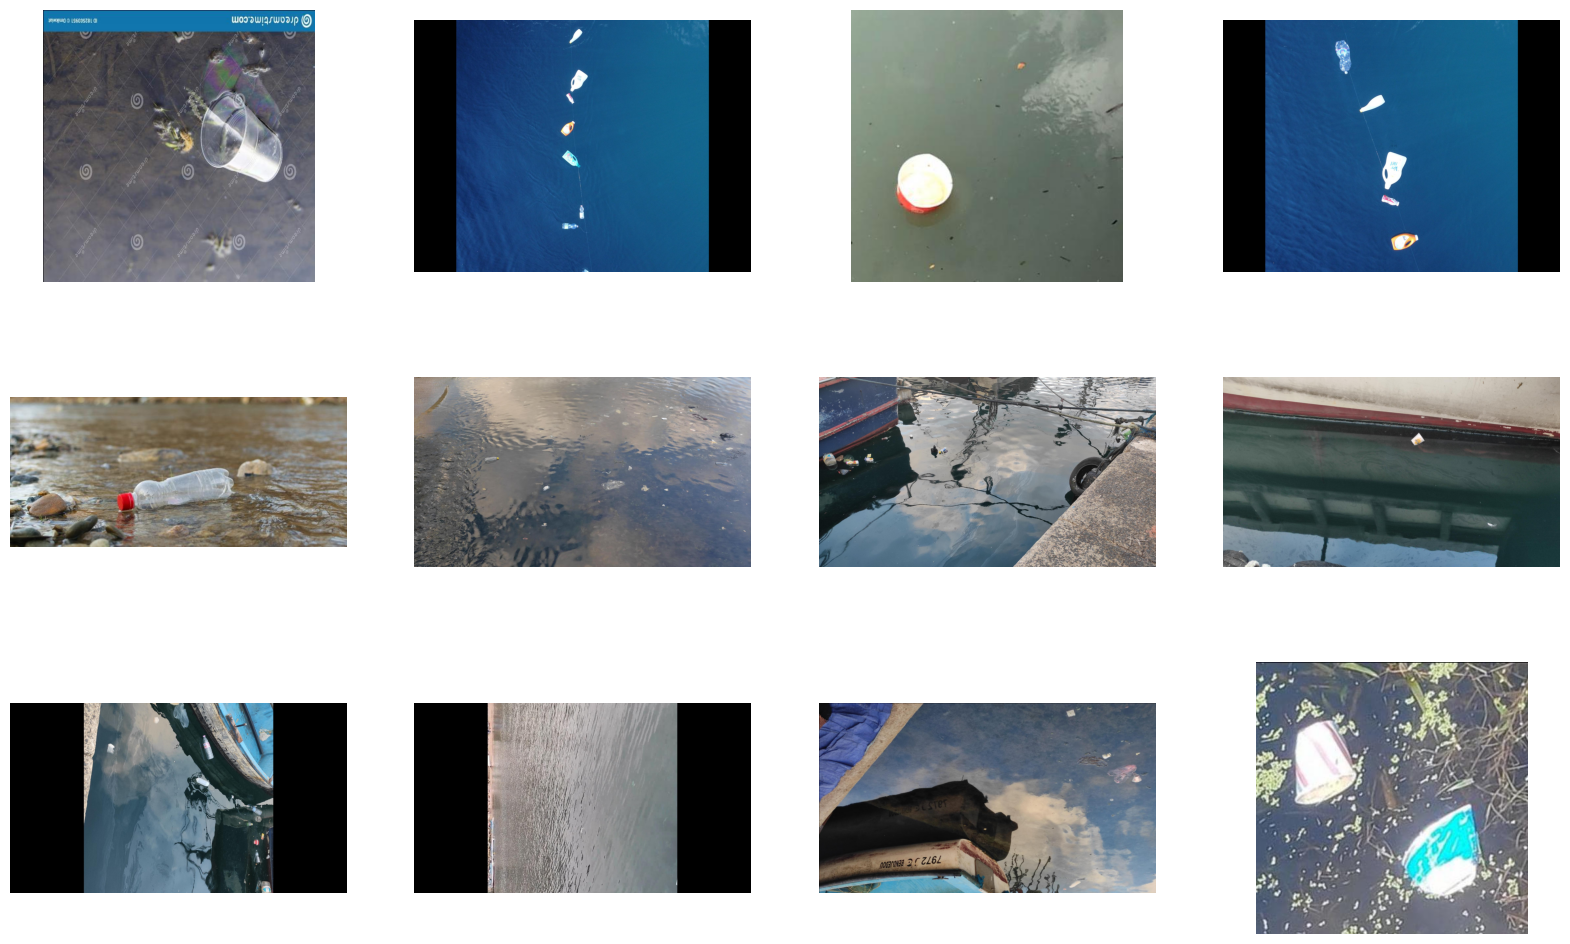

In [ ]:
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

train_path = "/content/train/images"
files = os.listdir(train_path)

sample_files = random.sample(files, 12)   # pick 12 images

plt.figure(figsize=(20,12))
for i, file in enumerate(sample_files):
    img = Image.open(os.path.join(train_path, file))
    plt.subplot(3,4,i+1)   # 3 rows, 4 columns
    plt.imshow(img)
    plt.axis("off")
plt.show()



In [ ]:
import os

paths = [
    "/content/train/images",
    "/content/train/labels",
    "/content/valid/images",
    "/content/valid/labels",
    "/content/test/images",
    "/content/test/labels",
]

for p in paths:
    print(p, "OK" if os.path.exists(p) else "MISSING")


/content/train/images OK
/content/train/labels OK
/content/valid/images OK
/content/valid/labels OK
/content/test/images OK
/content/test/labels OK


In [ ]:
from ultralytics.utils.checks import check_yaml

print(check_yaml('data.yaml'))


data.yaml


In [ ]:
import os
import yaml

# ---------- USER CONFIG ----------
DATA_ROOT = "/content"
LABEL_DIRS = [
    os.path.join(DATA_ROOT, "train", "labels"),
    os.path.join(DATA_ROOT, "valid", "labels"),
]
TEST_LABEL_DIR = os.path.join(DATA_ROOT, "test", "labels")
DATA_YAML = os.path.join(DATA_ROOT, "data.yaml")

# Add test directory if present
if os.path.exists(TEST_LABEL_DIR):
    LABEL_DIRS.append(TEST_LABEL_DIR)

# ---------- MAPPING (OLD -> NEW) ----------
# Final classes:
# 0: Plastic Packaging (merge old 4, 7, 9)
# 1: Plastic Bag (old 5)
# 2: Plastic Bottle (old 6)
# 3: Plastic Cup (old 8)
# 4: Undefined Trash (old 11)

mapping = {
    0: None,
    1: None,
    2: None,
    3: None,
    4: 0,     # Plastic → Plastic Packaging
    5: 1,     # Plastic Bag
    6: 2,     # Plastic Bottle
    7: 0,     # Plastic Waste → Plastic Packaging
    8: 3,     # Plastic Cup
    9: 0,     # Plastic Packaging → Plastic Packaging
    10: None,
    11: 4
}

# ---------- NEW CLASS NAMES ----------
new_class_names = [
    "Plastic Packaging",   # updated name
    "Plastic Bag",
    "Plastic Bottle",
    "Plastic Cup",
    "Undefined Trash",
]

# ---------- LABEL FIX FUNCTION ----------
def fix_labels(folder, mapping):
    if not os.path.isdir(folder):
        print(f"Skipping (not a dir): {folder}")
        return

    print(f"Processing labels in: {folder}")
    files_processed = 0

    for fname in os.listdir(folder):
        if not fname.lower().endswith(".txt"):
            continue

        path = os.path.join(folder, fname)
        new_lines = []

        with open(path, "r") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue

                parts = line.split()
                if len(parts) < 5:
                    continue

                try:
                    old_id = int(parts[0])
                except:
                    continue

                new_id = mapping.get(old_id, None)
                if new_id is None:
                    continue

                parts[0] = str(new_id)
                new_lines.append(" ".join(parts))

        with open(path, "w") as f:
            if new_lines:
                f.write("\n".join(new_lines) + "\n")
            else:
                f.write("")

        files_processed += 1

    print(f"Completed: {files_processed} label files in {folder}\n")

# ---------- UPDATE data.yaml ----------
def update_data_yaml(yaml_path, new_names):
    if not os.path.exists(yaml_path):
        print(f"data.yaml not found at {yaml_path}. Skipping.")
        return

    with open(yaml_path, "r") as f:
        data = yaml.safe_load(f)

    if data is None:
        data = {}

    data['nc'] = len(new_names)
    data['names'] = {i: name for i, name in enumerate(new_names)}

    with open(yaml_path, "w") as f:
        yaml.dump(data, f, default_flow_style=False, sort_keys=False)

    print(f"Updated data.yaml with classes:\n{data['names']}\n")

# ---------- RUN ----------
if __name__ == "__main__":
    for label_dir in LABEL_DIRS:
        fix_labels(label_dir, mapping)

    update_data_yaml(DATA_YAML, new_class_names)

    print("Final Classes:")
    for i, n in enumerate(new_class_names):
        print(f"{i}: {n}")


Processing labels in: /content/train/labels
Completed: 3625 label files in /content/train/labels

Processing labels in: /content/valid/labels
Completed: 163 label files in /content/valid/labels

Processing labels in: /content/test/labels
Completed: 89 label files in /content/test/labels

Updated data.yaml with classes:
{0: 'Plastic Packaging', 1: 'Plastic Bag', 2: 'Plastic Bottle', 3: 'Plastic Cup', 4: 'Undefined Trash'}

Final Classes:
0: Plastic Packaging
1: Plastic Bag
2: Plastic Bottle
3: Plastic Cup
4: Undefined Trash


In [ ]:
import yaml

with open("data.yaml", "r") as f:
    print(f.read())


train: ../train/images
val: ../valid/images
test: ../test/images
nc: 5
names:
  0: Plastic Packaging
  1: Plastic Bag
  2: Plastic Bottle
  3: Plastic Cup
  4: Undefined Trash



In [ ]:
import torchvision.transforms as transforms
image_size = (256, 256)

train_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])


valid_test_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class TrashDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        self.image_filenames.sort()

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        label_name = os.path.splitext(img_name)[0] + '.txt'
        label_path = os.path.join(self.label_dir, label_name)


        with open(label_path, 'r') as f:
            lines = [line.strip() for line in f if line.strip()]
            if not lines:
                 print(f"Warning: Empty label file found for {img_name}. Assigning label 0.")
                 label = 0
            else:
                try:
                    label = int(lines[0].split()[0])
                except (ValueError, IndexError):
                     print(f"Warning: Unexpected content in label file {label_name}. Assigning label 0.")
                     label = 0


        if self.transform:
            image = self.transform(image)

        return image, label


train_dataset = TrashDataset(image_dir='train/images', label_dir='train/labels', transform=train_transforms)
valid_dataset = TrashDataset(image_dir='valid/images', label_dir='valid/labels', transform=valid_test_transforms)
test_dataset = TrashDataset(image_dir='test/images', label_dir='test/labels', transform=valid_test_transforms)

print(f"Number of images in training dataset: {len(train_dataset)}")
print(f"Number of images in validation dataset: {len(valid_dataset)}")
print(f"Number of images in test dataset: {len(test_dataset)}")

Number of images in training dataset: 3625
Number of images in validation dataset: 163
Number of images in test dataset: 89


In [ ]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of batches in training loader: {len(train_loader)}")
print(f"Number of batches in validation loader: {len(valid_loader)}")
print(f"Number of batches in test dataset: {len(test_dataset)}")

Number of batches in training loader: 57
Number of batches in validation loader: 3
Number of batches in test dataset: 89


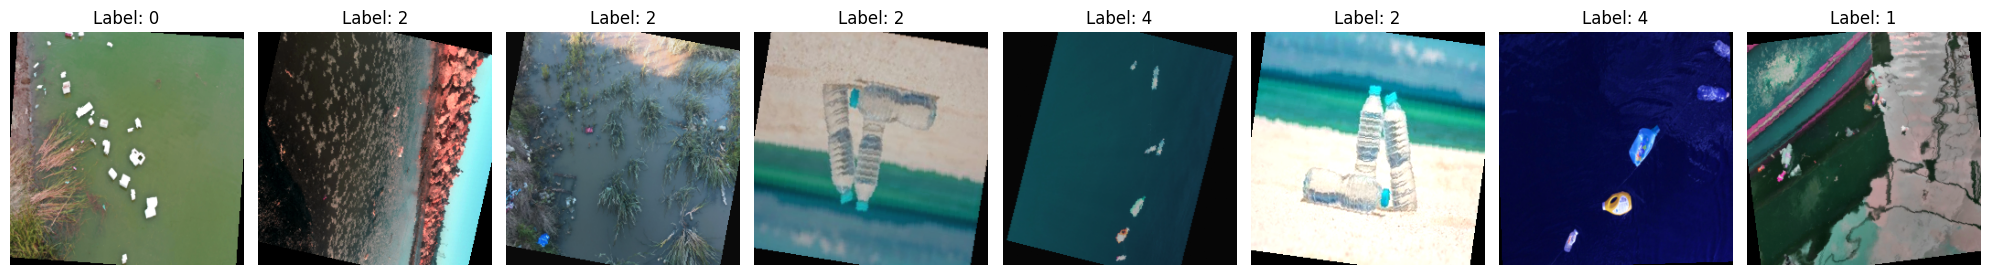

In [ ]:
import matplotlib.pyplot as plt

train_dataset = TrashDataset(image_dir='train/images', label_dir='train/labels', transform=train_transforms)
valid_dataset = TrashDataset(image_dir='valid/images', label_dir='valid/labels', transform=valid_test_transforms)
test_dataset = TrashDataset(image_dir='test/images', label_dir='test/labels', transform=valid_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

images, labels = next(iter(train_loader))

num_images_to_display = 8
selected_images = images[:num_images_to_display]
selected_labels = labels[:num_images_to_display]

selected_images_np = selected_images.permute(0, 2, 3, 1).numpy()

fig, axes = plt.subplots(1, num_images_to_display, figsize=(20, 4))

for i in range(num_images_to_display):
    ax = axes[i]
    ax.imshow(selected_images_np[i])
    ax.set_title(f'Label: {selected_labels[i].item()}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
individual_augmentations = [
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
]

individual_transform_sequences = []
for aug_transform in individual_augmentations:
    sequence = transforms.Compose([
        transforms.Resize(image_size),
        aug_transform,
        transforms.ToTensor(),
    ])
    individual_transform_sequences.append(sequence)

In [ ]:
original_dataset = TrashDataset(image_dir='train/images', label_dir='train/labels', transform=None)
sample_image, sample_label = original_dataset[600]

print(f"Original image format: {type(sample_image)}")
print(f"Original image size: {sample_image.size}")
print(f"Original image label: {sample_label}")

Original image format: <class 'PIL.Image.Image'>
Original image size: (2048, 1536)
Original image label: 1


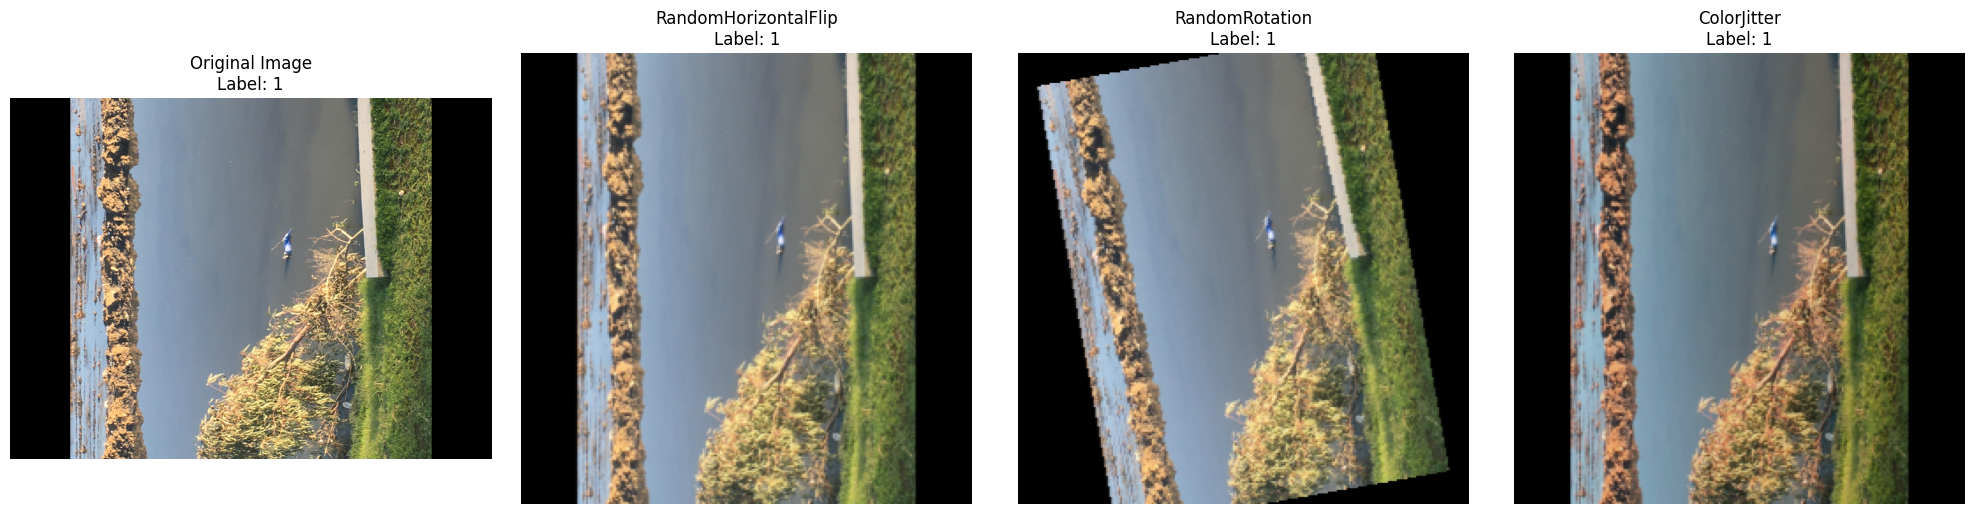

In [ ]:
num_augmentations = len(individual_transform_sequences)

num_subplots = 1 + num_augmentations


fig, axes = plt.subplots(1, num_subplots, figsize=(5 * num_subplots, 5))


ax_original = axes[0]
ax_original.imshow(sample_image)
ax_original.set_title(f"Original Image\nLabel: {sample_label}")
ax_original.axis('off')

for i, transform_sequence in enumerate(individual_transform_sequences):
    ax = axes[i + 1]
    augmented_image_tensor = transform_sequence(sample_image)
    augmented_image_np = augmented_image_tensor.permute(1, 2, 0).numpy()
    ax.imshow(augmented_image_np)
    augmentation_name = type(transform_sequence.transforms[1]).__name__
    ax.set_title(f"{augmentation_name}\nLabel: {sample_label}")
    ax.axis('off')


plt.tight_layout()
plt.show()